In [20]:
import json
import pandas as pd
import seaborn as sns
import re
import pickle
import mowl
mowl.init_jvm("4g")
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt

First we have to read the ontology graph

In [21]:
Onto_graph_raw = []
with (open("../../Data/Input/Graph_mesh_OWL2VEC.pkl", "rb")) as openfile:
    while True:
        try:
            Onto_graph_raw.append(pickle.load(openfile))
        except EOFError:
            break

Here we are formatting the information of the projected graph in a more efficient data structure.

In [22]:

id2idx = {}
idx_ref = -1

# A weird term is a term that not complies with the MeSH format of ids, MeSH_id examples = "D007484", "T083", "Q000266"
def findWeirTerm(term, dict):
    if(len(re.findall("[A-Z]+[0-9]+", term)) == 0):
        if(term in dict): dict[term] += 1
        else: dict[term] = 1
    return dict

def getIdx(id):
    if(id in id2idx):
        return id2idx[id]
    else:
        global idx_ref
        idx_ref+=1
        id2idx[id] = idx_ref
        id2idx[idx_ref] = id
        
        return idx_ref

def format_Big(raw_graph):
    v = 0
    new_G = nx.DiGraph()
    weird_terms = {}
    for section in raw_graph:
        for edge in section:
            # print(edge.src)
            src = edge.src.split("/")[-1]
            rel = edge.rel.split("/")[-1]
            dst = edge.dst.split("/")[-1]
            
            weird_terms = findWeirTerm(src,weird_terms)
            weird_terms = findWeirTerm(dst,weird_terms)
            
            if(rel == "superclassof"):
                new_G.add_edge(getIdx(src),getIdx(dst))
    
    print(weird_terms)
    return new_G

big_G = format_Big(Onto_graph_raw)

{'owl#Thing': 236, 'core#OrderedCollection': 3, 'core#Collection': 2, '22-rdf-syntax-ns#List': 1, 'core#Concept': 12, 'core#ConceptScheme': 4}


## Visualize part of the graph

I think the root of the tree is owl#Thing, we want to create the bfs tree from the root and assign a lvl to the nodes that we find on the way.

In [23]:
def dfs_tree_from(source_node):
    tree = nx.bfs_tree(big_G, source=id2idx[source_node], depth_limit=1)
    print(id2idx[source_node],len(tree))
    nx.draw_spring(tree,with_labels = True)

393 62


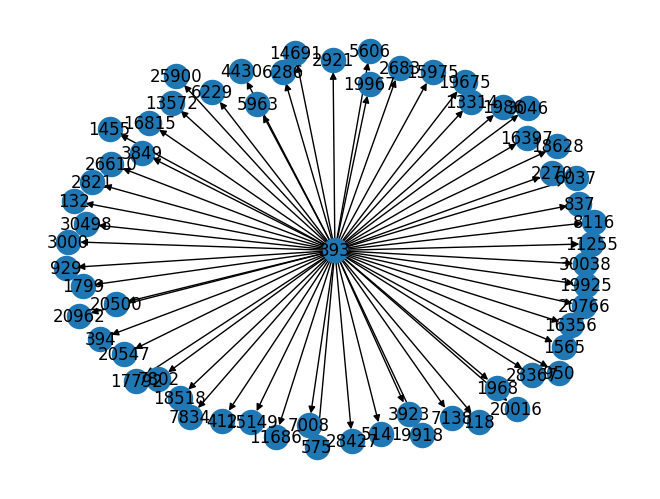

In [24]:
dfs_tree_from("D013514")

696 119


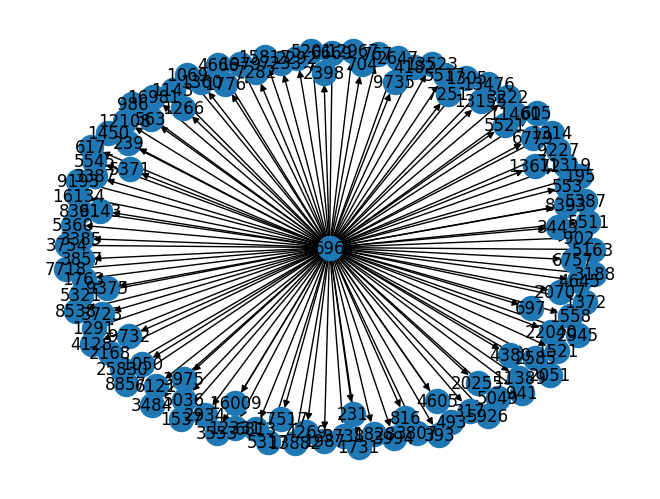

In [25]:
dfs_tree_from("owl#Thing")

## Create a depth attribute

Now we want each node to have a depth.

In [26]:
print(nx.is_tree(big_G))
print(nx.is_forest(big_G))
print(nx.is_branching(big_G))

False
False
False


In [27]:
node = id2idx["owl#Thing"]    
print(node,id2idx[node])
ancestor = nx.bfs_successors(big_G, source=node, depth_limit=1)
for lst in ancestor:
    # print(lst)
    for elem in lst[1]:
        print(id2idx[elem])

696 owl#Thing
D006730
D004703
D008055
D055827
D004700
U000018
D001105
D008919
U000016
D004472
D004628
U000017
D020164
D006809
D002468
D004864
D006281
D009358
D004493
D006802
D007287
D010829
D004778
D000091642
D013812
D009420
D017530
D013568
D001520
D017437
D018514
D009422
D012101
D001523
D009784
D014780
D014566
D004066
D009057
D046911
D011579
D004064
D009272
D001685
D008660
D056891
D055598
D001686
D056890
D002319
D011083
D052180
D034582
D002318
D004191
D010038
D013514
D000602
D055687
D012140
D064419
D012679
D006298
D055688
D004364
D013284
D005441
D007254
D045424
D012942
D055641
D009369
D006425
D013676
D006424
D009930
D045762
D002477
D005128
D000760
D007154
D002943
D009706
D011154
D001419
D005842
D055633
D056224
D052288
D012137
D014024
D056226
D000825
D007280
D003813
D003933
D006571
D005159
D055614
D056229
D019602
D000072182
D009799
D014947
D002241
D008827
D010811
D009140
D009750
D001697
D009141
D052182
D001829
D055585
D007239
D000820
D018521
D052181


Once we find the root of the tree, we can use 
```
    nx.descendants_at_distance(G, source, distance)
```
or
```
    nx.bfs_layers(G, sources)
```
To determine the depth of the nodes and create our input file, for the next layer

In [28]:
node_depth = {}
layers = nx.bfs_layers(big_G,id2idx['owl#Thing'])
layers_dict = dict(enumerate(layers))
for k,v in layers_dict.items():
    print("Depth",k)
    for node in v:
        node_depth[node] = k
# print(node_depth)

Depth 0
Depth 1
Depth 2
Depth 3
Depth 4
Depth 5
Depth 6
Depth 7
Depth 8
Depth 9
Depth 10
Depth 11
Depth 12
Depth 13


Now lets add a property to each node representing the depth they have.

In [29]:
nx.set_node_attributes(big_G, node_depth, "Depth")
print(big_G.nodes[5360]["Depth"])

1


Now the last step is to save the graph with its respective depths.

In [30]:
# print(json_graph.node_link_data(big_G))
with open("../../Data/Output/MeSH_graph_with_depth.json", "w") as fp:
            json.dump(json_graph.node_link_data(big_G),fp,indent = 2) 

## Frequency analysis of MeSH terms in Pubmed abstracts

First we will load a dataset that contains pubmed abstracts and their respective MeSH and STY terms.

In [31]:
df_TP = pd.DataFrame()
MeSH_cnt = {}

'''
    Function to load the complete topic_categorization dataset. 

    Input:  path -> The path location of the topic_categorization dataset in tsv format.
    Output: A DataFrame with all the topic_categorization dataset "PMID", "Title/Abstract", "MeshTerms","SemanticTypes"
'''
def load_Dataset(path):
    global df_TP
    df_TP = pd.read_csv(path,sep='\t')
    print(df_TP.head())

load_Dataset("../../Data/Input/pubmed_abstracts+MeSH+STY_dataset.tsv")

       PMID                                     Title/Abstract  \
0  34694464  limit use dithionit quench determin topolog me...   
1  34694463  isol post traumat astereognosi case base revie...   
2  34694462  loss chromatin remodel ddm caus segreg distort...   
3  34694461  identif novel genom wide pleiotrop associ oral...   
4  34694460  rare frequent lethal complic pulmonari vein is...   

                         MeshTerms             SemanticTypes  
0                  D005456;D008565       T130;T192;T116;T123  
1                  D006225;D013236                 T039;T023  
2                  D017360;D029681                 T116;T002  
3                          D058685                 T028;T045  
4  D001281;D017115;D004937;D011667  T023;T047;T046;T190;T061  


In [32]:
'''
    Function  count of the appearances of a MeSH terms in the pubmed_abstracts+MeSH+STY dataset.

    Input:  
    Output: A Dictionary with the  count of the appearances of a STY, when an STY appears its parents as well appear   
            {graph_id : CNT}
'''
def count_MeSH_in_Dataset():
    for i in df_TP.index: 
        #print(df_semantic["Semantic Types"][i])
        split_types = df_TP["MeshTerms"][i].split(";")
        #print(split_types)
        for s_type_link in split_types:
            s_type = s_type_link.split("/")[-1]
            # print(s_type)
            if s_type in id2idx:
                s_type_id = id2idx[s_type]
                if(s_type_id in MeSH_cnt):
                    MeSH_cnt[s_type_id] = MeSH_cnt[s_type_id] + 1
                else:
                    MeSH_cnt[s_type_id] = 1

    #print(sorted(MeSH_cnt.items(), key=lambda kv:(-kv[1], -kv[0])))

count_MeSH_in_Dataset()

In [33]:
for k,v in node_depth.items():
    if(k not in MeSH_cnt):
        MeSH_cnt[k] = 0
        
nx.set_node_attributes(big_G, MeSH_cnt, "Frequency_Pubmed")
print(big_G.nodes[5360]["Frequency_Pubmed"])

0


In [34]:
with open("../../Data/Output/MeSH_graph_with_depth+freq.json", "w") as fp:
            json.dump(json_graph.node_link_data(big_G),fp,indent = 2) 

## Frequency visualization

In [35]:
i = 0
Depth_vs_freq = {}

for i in range(0,12):
    Depth_vs_freq[i] = 0
    
for node_id in big_G.nodes:
    dpth = big_G.nodes[node_id]["Depth"]
    freq = big_G.nodes[node_id]["Frequency_Pubmed"]
    if(dpth in Depth_vs_freq): Depth_vs_freq[dpth] += freq  
    i+=1
    # if(i == 20): break

print(Depth_vs_freq)
sns.boxplot(x=list(Depth_vs_freq.keys()), y=list(Depth_vs_freq.values()))

KeyError: 'Depth'